In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler

import math

In [3]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
        X = np.array(X).reshape(48,48,1)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(np.uint8(X))

            X = torch.cat((X,X,X),0)

        return X, y

In [4]:
batch_size= 128

df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_set = FERDataset(df_train, train_transforms)
val_set = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
class SVblock(nn.Module):
    def __init__(self, in_neurons, nb_neurons, kernel_size=(3,3), batch_norm=True, activation='relu', **kwargs):
        '''
    in_neurons: C_in
    nb_neurons: n_filters of conv2d
    '''
        super(SVblock, self).__init__()

        self.index = kwargs['index'] if 'index' in kwargs else None
        self.conv1 = nn.Conv2d(in_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv2 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv3 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        
        self.bn1 = nn.BatchNorm2d(nb_neurons)
        self.bn2 = nn.BatchNorm2d(nb_neurons)
        self.bn3 = nn.BatchNorm2d(nb_neurons)
        
        self.preconv1 = nn.Conv2d(in_neurons, nb_neurons, kernel_size=1)
        self.preconv2 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=1)
        self.preconv3 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=1)
        self.bn1_ = nn.BatchNorm2d(nb_neurons)
        self.bn2_ = nn.BatchNorm2d(nb_neurons)
        self.bn3_ = nn.BatchNorm2d(nb_neurons)
        
        self.relu = nn.LeakyReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
     


    def forward(self, x):        
        
        x0_res = self.preconv1(x)
        x0_res = self.bn1_(x0_res)
        
        # 1st
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = x1 + x0_res
        x1 = self.relu(x1)
        
        x1_res = self.preconv2(x1)
        x1_res = self.bn2_(x1_res)

        # 2nd
        x2 = self.conv2(x1)
        x2 = self.bn2(x2)
        x2 = x2 + x1_res
        x2 = self.relu(x2)
        
        x2_res = self.preconv3(x2)
        x2_res = self.bn3_(x2_res)
        
        # 3rd
        x3 = self.conv3(x2)
        x3 = self.bn3(x3)
        x3 = x3 + x2_res
        x3 = self.relu(x3)

        # maxpooling
        x_out = self.maxpool(x3)

        return x_out
    
class Attention(nn.Module):
    
    def __init__(self, feature_depth, target_depth, emb_dim, **kwargs):
        super(Attention, self).__init__()
        
        self.emb_dim = emb_dim
#         self.device = kwargs['device']
        
        self.iconv1 = nn.Conv2d(feature_depth, emb_dim, kernel_size=1)
        self.iconv2 = nn.Conv2d(target_depth, emb_dim, kernel_size=1)
        self.iconv3 = nn.Conv2d(target_depth, emb_dim, kernel_size=1)
        self.iconv_out = nn.Conv2d(emb_dim, target_depth, kernel_size=1)
        self.bn_out = nn.BatchNorm2d(target_depth)
        
        # ensure the init stage is the indentical mapping
#         nn.init.zeros_(self.iconv_out.weight)
#         nn.init.zeros_(self.iconv_out.bias)
#         nn.init.zeros_(self.bn_out.weight)
#         nn.init.zeros_(self.bn_out.bias)
        
    def forward(self, x):
        x1_emb = self.iconv1(x)
        _x1 = nn.Flatten(-2)(x1_emb)
        
        x2_emb = self.iconv2(x)
        _x2 = nn.Flatten(-2)(x2_emb)
        
        x3_emb = self.iconv3(x)
        
        QK = torch.matmul(_x1, _x2.permute(0,2,1))
        QK = QK / QK.size(1)
        QK = torch.matmul(QK, QK.permute(0,2,1)).sum(1)
        QK = QK.sigmoid()
        QK = QK.unsqueeze(-1).unsqueeze(-1)
        
        
        x_out = (1 + QK) * x3_emb
        x_out = self.iconv_out(x_out)
        x_out = self.bn_out(x_out)
        x_out = nn.LeakyReLU(inplace=True)(x_out)
        
        x_out = x_out + x #residual
        
        return x_out
    
class SVGG(nn.Module):
    
    def __init__(self, **kwargs):
        super(SVGG, self).__init__()

        self.device = torch.device('cpu') if not 'device' in kwargs else kwargs['device']

        self.sv0 = SVblock(1, 64).to(self.device)
        self.sv1 = SVblock(64, 128).to(self.device)
        self.sv2 = SVblock(128, 256).to(self.device)
        self.sv3 = SVblock(256, 512).to(self.device)
        self.sv4 = SVblock(512, 1024).to(self.device)

        self.wf0 = Attention(64, 64, emb_dim=32).to(self.device)
        self.wf1 = Attention(128, 128, emb_dim=64).to(self.device)
        self.wf2 = Attention(256, 256, emb_dim=128).to(self.device)
        self.wf3 = Attention(512, 512, emb_dim=256).to(self.device)
        self.wf4 = Attention(1024, 1024, emb_dim=512).to(self.device)

        self.fc1 = nn.Linear(1024, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 7)
        self.bn2 = nn.BatchNorm1d(7)
        
    
    def forward(self, x):
        x0 = self.sv0(x)
        x_wf0 = self.wf0(x0)

        x1 = self.sv1(x_wf0)
        x_wf1 = self.wf1(x1)

        x2 = self.sv2(x_wf1)
        x_wf2 = self.wf2(x2)

        x3 = self.sv3(x_wf2)
        x_wf3 = self.wf3(x3)
        
        x4 = self.sv4(x_wf3)
        x_wf4 = self.wf4(x4)

        x_wf4 = nn.AvgPool2d(kernel_size=(x_wf4.size(-2), x_wf4.size(-1)))(x_wf4)
    
        x = nn.Flatten()(x_wf4)

        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.LeakyReLU()(x)
        x = self.fc2(x)
        x = self.bn2(x)

        return x

In [7]:
device = torch.device('cuda')
print(device)

model = SVGG(device=device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.008
reduce_factor = 5
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

cuda


In [ ]:
model = model.to(device)

# model_folder = '/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention/'
# model_name = 'svgg_resnet4'
# model_path = os.path.join(model_folder, model_name + '.pt')
model_path = './temp_model.pt'

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(300):  # loop over the dataset multiple times
    
    if (epoch % 60) == 0 and epoch != 0:
        learning_rate /= reduce_factor
        print('Decrese learning rate to: ', learning_rate)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i}  Accuracy={100*running_acc/processed:0.2f}')

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum())
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalcc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / len(val_loader.dataset)):
        best_acc = (running_valacc / len(val_loader.dataset))
        curloss = (running_valloss / len(val_loader.dataset))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.642636775970459 Batch_id=224  Accuracy=44.76: 100%|██████████| 225/225 [00:47<00:00,  4.69it/s] 

- Avg.loss: 1.492  | Avg.acc: 0.448


- Avg. val_loss: 1.532  | Avg. val_acc: 0.441


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  2


Loss=1.4305814504623413 Batch_id=224  Accuracy=50.89: 100%|██████████| 225/225 [00:48<00:00,  4.68it/s]

- Avg.loss: 1.354  | Avg.acc: 0.509


- Avg. val_loss: 1.441  | Avg. val_acc: 0.459


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.0935077667236328 Batch_id=224  Accuracy=55.37: 100%|██████████| 225/225 [00:48<00:00,  4.67it/s]

- Avg.loss: 1.245  | Avg.acc: 0.554



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.451  | Avg. val_acc: 0.452
Epoch:  4


Loss=1.3570170402526855 Batch_id=224  Accuracy=59.22: 100%|██████████| 225/225 [00:48<00:00,  4.66it/s]

- Avg.loss: 1.150  | Avg.acc: 0.592



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.551  | Avg. val_acc: 0.433
Epoch:  5


Loss=1.1407021284103394 Batch_id=224  Accuracy=63.04: 100%|██████████| 225/225 [00:48<00:00,  4.65it/s]

- Avg.loss: 1.060  | Avg.acc: 0.630


- Avg. val_loss: 1.340  | Avg. val_acc: 0.518


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=0.9492621421813965 Batch_id=224  Accuracy=66.48: 100%|██████████| 225/225 [00:48<00:00,  4.65it/s]

- Avg.loss: 0.979  | Avg.acc: 0.665



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.336  | Avg. val_acc: 0.515
Epoch:  7


Loss=1.029589056968689 Batch_id=224  Accuracy=69.89: 100%|██████████| 225/225 [00:48<00:00,  4.66it/s] 

- Avg.loss: 0.893  | Avg.acc: 0.699



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.410  | Avg. val_acc: 0.483
Epoch:  8


Loss=1.1077576875686646 Batch_id=224  Accuracy=73.78: 100%|██████████| 225/225 [00:48<00:00,  4.66it/s]

- Avg.loss: 0.804  | Avg.acc: 0.738



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.438  | Avg. val_acc: 0.505
Epoch:  9


Loss=0.8295879364013672 Batch_id=224  Accuracy=76.99: 100%|██████████| 225/225 [00:48<00:00,  4.66it/s]

- Avg.loss: 0.723  | Avg.acc: 0.770



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.437  | Avg. val_acc: 0.509
Epoch:  10


Loss=0.6749847531318665 Batch_id=224  Accuracy=81.12: 100%|██████████| 225/225 [00:48<00:00,  4.66it/s] 

- Avg.loss: 0.629  | Avg.acc: 0.811


- Avg. val_loss: 1.425  | Avg. val_acc: 0.519


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=0.7526477575302124 Batch_id=224  Accuracy=84.54: 100%|██████████| 225/225 [00:48<00:00,  4.65it/s] 

- Avg.loss: 0.544  | Avg.acc: 0.845



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.517  | Avg. val_acc: 0.503
Epoch:  12


Loss=0.5256912708282471 Batch_id=224  Accuracy=87.19: 100%|██████████| 225/225 [00:48<00:00,  4.65it/s] 

- Avg.loss: 0.474  | Avg.acc: 0.872



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.570  | Avg. val_acc: 0.502
Epoch:  13


Loss=0.5385755300521851 Batch_id=224  Accuracy=90.30: 100%|██████████| 225/225 [00:48<00:00,  4.65it/s] 

- Avg.loss: 0.392  | Avg.acc: 0.903


- Avg. val_loss: 1.508  | Avg. val_acc: 0.536


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  14


Loss=0.4919387698173523 Batch_id=224  Accuracy=92.98: 100%|██████████| 225/225 [00:48<00:00,  4.65it/s] 

- Avg.loss: 0.325  | Avg.acc: 0.930


- Avg. val_loss: 1.476  | Avg. val_acc: 0.541


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  15


Loss=1.1413733959197998 Batch_id=224  Accuracy=94.26: 100%|██████████| 225/225 [00:48<00:00,  4.65it/s] 

- Avg.loss: 0.280  | Avg.acc: 0.943



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.290  | Avg. val_acc: 0.310
Epoch:  16


Loss=0.7561447024345398 Batch_id=224  Accuracy=76.43: 100%|██████████| 225/225 [00:48<00:00,  4.67it/s] 

- Avg.loss: 0.687  | Avg.acc: 0.764



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.622  | Avg. val_acc: 0.490
Epoch:  17


Loss=0.4598708152770996 Batch_id=224  Accuracy=84.95: 100%|██████████| 225/225 [00:48<00:00,  4.66it/s] 

- Avg.loss: 0.480  | Avg.acc: 0.850



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.562  | Avg. val_acc: 0.518
Epoch:  18


Loss=0.2651044726371765 Batch_id=224  Accuracy=92.23: 100%|██████████| 225/225 [00:48<00:00,  4.66it/s] 

- Avg.loss: 0.311  | Avg.acc: 0.922


- Avg. val_loss: 1.427  | Avg. val_acc: 0.559


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  19


Loss=0.3458894193172455 Batch_id=224  Accuracy=95.26: 100%|██████████| 225/225 [00:48<00:00,  4.67it/s] 

- Avg.loss: 0.231  | Avg.acc: 0.953



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.450  | Avg. val_acc: 0.548
Epoch:  20


Loss=0.17369896173477173 Batch_id=145  Accuracy=97.29:  65%|██████▍   | 146/225 [00:31<00:16,  4.71it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.029108237475156784 Batch_id=224  Accuracy=99.72: 100%|██████████| 225/225 [00:48<00:00,  4.66it/s]

- Avg.loss: 0.030  | Avg.acc: 0.997


- Avg. val_loss: 1.294  | Avg. val_acc: 0.597


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  39


Loss=0.05916863679885864 Batch_id=224  Accuracy=99.72: 100%|██████████| 225/225 [00:48<00:00,  4.65it/s] 

- Avg.loss: 0.029  | Avg.acc: 0.997



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.305  | Avg. val_acc: 0.590
Epoch:  40


Loss=0.036526117473840714 Batch_id=224  Accuracy=99.76: 100%|██████████| 225/225 [00:48<00:00,  4.66it/s]

- Avg.loss: 0.027  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.305  | Avg. val_acc: 0.596
Epoch:  41


Loss=0.02276425249874592 Batch_id=224  Accuracy=99.71: 100%|██████████| 225/225 [00:48<00:00,  4.65it/s] 

- Avg.loss: 0.027  | Avg.acc: 0.997



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.311  | Avg. val_acc: 0.591
Epoch:  42


Loss=0.04756191745400429 Batch_id=224  Accuracy=99.76: 100%|██████████| 225/225 [00:48<00:00,  4.66it/s] 

- Avg.loss: 0.025  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.310  | Avg. val_acc: 0.591
Epoch:  43


Loss=0.03640997037291527 Batch_id=224  Accuracy=99.72: 100%|██████████| 225/225 [00:48<00:00,  4.65it/s] 

- Avg.loss: 0.026  | Avg.acc: 0.997



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.321  | Avg. val_acc: 0.589
Epoch:  44


Loss=0.03562281280755997 Batch_id=224  Accuracy=99.76: 100%|██████████| 225/225 [00:48<00:00,  4.66it/s] 

- Avg.loss: 0.024  | Avg.acc: 0.998


- Avg. val_loss: 1.315  | Avg. val_acc: 0.597


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  45


Loss=0.01856844127178192 Batch_id=76  Accuracy=99.87:  34%|███▍      | 76/225 [00:16<00:31,  4.70it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=1.0884697437286377 Batch_id=224  Accuracy=49.10: 100%|██████████| 225/225 [00:53<00:00,  4.18it/s]

- Avg.loss: 1.309  | Avg.acc: 0.491



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.704  | Avg. val_acc: 0.363
Epoch:  63


Loss=0.9939851760864258 Batch_id=224  Accuracy=54.10: 100%|██████████| 225/225 [00:53<00:00,  4.19it/s]

- Avg.loss: 1.199  | Avg.acc: 0.541



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.165  | Avg. val_acc: 0.551
Epoch:  64


Loss=1.0780774354934692 Batch_id=224  Accuracy=57.30: 100%|██████████| 225/225 [00:53<00:00,  4.19it/s]

- Avg.loss: 1.122  | Avg.acc: 0.573



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.182  | Avg. val_acc: 0.555
Epoch:  65


Loss=1.01028311252594 Batch_id=224  Accuracy=58.84: 100%|██████████| 225/225 [00:53<00:00,  4.19it/s]  

- Avg.loss: 1.084  | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.347  | Avg. val_acc: 0.500
Epoch:  66


Loss=1.140484094619751 Batch_id=224  Accuracy=60.86: 100%|██████████| 225/225 [00:53<00:00,  4.18it/s] 

- Avg.loss: 1.043  | Avg.acc: 0.609



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.287  | Avg. val_acc: 0.537
Epoch:  67


Loss=1.1243960857391357 Batch_id=224  Accuracy=61.92: 100%|██████████| 225/225 [00:53<00:00,  4.19it/s]

- Avg.loss: 1.016  | Avg.acc: 0.619



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.156  | Avg. val_acc: 0.561
Epoch:  68


Loss=1.3504592180252075 Batch_id=224  Accuracy=62.56: 100%|██████████| 225/225 [00:53<00:00,  4.20it/s]

- Avg.loss: 0.997  | Avg.acc: 0.626



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.133  | Avg. val_acc: 0.570
Epoch:  69


Loss=1.0298320055007935 Batch_id=94  Accuracy=64.03:  42%|████▏     | 94/225 [00:22<00:31,  4.22it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.8922399282455444 Batch_id=224  Accuracy=77.48: 100%|██████████| 225/225 [00:53<00:00,  4.22it/s]

- Avg.loss: 0.620  | Avg.acc: 0.775



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.274  | Avg. val_acc: 0.594
Epoch:  88


Loss=0.4766366183757782 Batch_id=224  Accuracy=78.60: 100%|██████████| 225/225 [00:53<00:00,  4.22it/s] 

- Avg.loss: 0.592  | Avg.acc: 0.786



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.108  | Avg. val_acc: 0.617
Epoch:  89


Loss=0.5745874047279358 Batch_id=224  Accuracy=79.61: 100%|██████████| 225/225 [00:53<00:00,  4.22it/s] 

- Avg.loss: 0.571  | Avg.acc: 0.796



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.137  | Avg. val_acc: 0.618
Epoch:  90


Loss=0.7292735576629639 Batch_id=224  Accuracy=80.38: 100%|██████████| 225/225 [00:53<00:00,  4.21it/s] 

- Avg.loss: 0.548  | Avg.acc: 0.804



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.143  | Avg. val_acc: 0.622
Epoch:  91


Loss=0.496204674243927 Batch_id=224  Accuracy=81.19: 100%|██████████| 225/225 [00:53<00:00,  4.21it/s]  

- Avg.loss: 0.527  | Avg.acc: 0.812



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.207  | Avg. val_acc: 0.619
Epoch:  92


Loss=0.8884140253067017 Batch_id=224  Accuracy=82.22: 100%|██████████| 225/225 [00:53<00:00,  4.22it/s] 

- Avg.loss: 0.504  | Avg.acc: 0.822



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.219  | Avg. val_acc: 0.591
Epoch:  93


Loss=0.44154149293899536 Batch_id=222  Accuracy=83.05:  99%|█████████▉| 223/225 [00:53<00:00,  4.25it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.4950218200683594 Batch_id=224  Accuracy=91.39: 100%|██████████| 225/225 [00:53<00:00,  4.22it/s] 

- Avg.loss: 0.251  | Avg.acc: 0.914



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.535  | Avg. val_acc: 0.622
Epoch:  112


Loss=0.26926833391189575 Batch_id=224  Accuracy=91.09: 100%|██████████| 225/225 [00:53<00:00,  4.21it/s]

- Avg.loss: 0.255  | Avg.acc: 0.911



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.485  | Avg. val_acc: 0.603
Epoch:  113


Loss=0.26006343960762024 Batch_id=224  Accuracy=91.42: 100%|██████████| 225/225 [00:53<00:00,  4.23it/s]

- Avg.loss: 0.249  | Avg.acc: 0.914



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.541  | Avg. val_acc: 0.618
Epoch:  114


Loss=0.3016093075275421 Batch_id=224  Accuracy=91.87: 100%|██████████| 225/225 [00:53<00:00,  4.22it/s] 

- Avg.loss: 0.238  | Avg.acc: 0.919



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.545  | Avg. val_acc: 0.602
Epoch:  115


Loss=0.17265771329402924 Batch_id=224  Accuracy=91.74: 100%|██████████| 225/225 [00:53<00:00,  4.22it/s]

- Avg.loss: 0.241  | Avg.acc: 0.917



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.467  | Avg. val_acc: 0.609
Epoch:  116


Loss=0.34803175926208496 Batch_id=224  Accuracy=92.30: 100%|██████████| 225/225 [00:53<00:00,  4.21it/s]

- Avg.loss: 0.226  | Avg.acc: 0.923



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.566  | Avg. val_acc: 0.603
Epoch:  117


Loss=0.13190455734729767 Batch_id=224  Accuracy=91.80: 100%|██████████| 225/225 [00:53<00:00,  4.23it/s]

- Avg.loss: 0.239  | Avg.acc: 0.918



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.705  | Avg. val_acc: 0.579
Epoch:  118


Loss=0.16406463086605072 Batch_id=127  Accuracy=93.01:  56%|█████▋    | 127/225 [00:30<00:23,  4.25it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.057060930877923965 Batch_id=224  Accuracy=99.21: 100%|██████████| 225/225 [00:53<00:00,  4.21it/s] 

- Avg.loss: 0.031  | Avg.acc: 0.992



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.927  | Avg. val_acc: 0.628
Epoch:  136


Loss=0.014962843619287014 Batch_id=224  Accuracy=99.26: 100%|██████████| 225/225 [00:53<00:00,  4.21it/s]

- Avg.loss: 0.028  | Avg.acc: 0.993



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.925  | Avg. val_acc: 0.629
Epoch:  137


Loss=0.044790271669626236 Batch_id=224  Accuracy=99.16: 100%|██████████| 225/225 [00:53<00:00,  4.22it/s] 

- Avg.loss: 0.030  | Avg.acc: 0.992



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.909  | Avg. val_acc: 0.633
Epoch:  138


Loss=0.010283703915774822 Batch_id=224  Accuracy=99.19: 100%|██████████| 225/225 [00:53<00:00,  4.21it/s] 

- Avg.loss: 0.030  | Avg.acc: 0.992



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.941  | Avg. val_acc: 0.634
Epoch:  139


Loss=0.0062342192977666855 Batch_id=224  Accuracy=99.22: 100%|██████████| 225/225 [00:53<00:00,  4.23it/s]

- Avg.loss: 0.029  | Avg.acc: 0.992



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.926  | Avg. val_acc: 0.637
Epoch:  140


Loss=0.012758949771523476 Batch_id=224  Accuracy=99.22: 100%|██████████| 225/225 [00:53<00:00,  4.22it/s] 

- Avg.loss: 0.029  | Avg.acc: 0.992



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.960  | Avg. val_acc: 0.638
Epoch:  141


Loss=0.10721755772829056 Batch_id=214  Accuracy=99.38:  95%|█████████▌| 214/225 [00:51<00:02,  4.27it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.06385523825883865 Batch_id=224  Accuracy=99.27: 100%|██████████| 225/225 [00:53<00:00,  4.22it/s]  

- Avg.loss: 0.024  | Avg.acc: 0.993



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.033  | Avg. val_acc: 0.638
Epoch:  160


Loss=0.0056383623741567135 Batch_id=224  Accuracy=98.93: 100%|██████████| 225/225 [00:53<00:00,  4.22it/s]

- Avg.loss: 0.032  | Avg.acc: 0.989



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.061  | Avg. val_acc: 0.627
Epoch:  161


Loss=0.034124955534935 Batch_id=224  Accuracy=99.15: 100%|██████████| 225/225 [00:53<00:00,  4.22it/s]    

- Avg.loss: 0.028  | Avg.acc: 0.992



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.009  | Avg. val_acc: 0.638
Epoch:  162


Loss=0.07883726060390472 Batch_id=224  Accuracy=99.25: 100%|██████████| 225/225 [00:53<00:00,  4.21it/s]  

- Avg.loss: 0.024  | Avg.acc: 0.992



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.061  | Avg. val_acc: 0.638
Epoch:  163


Loss=0.09724295884370804 Batch_id=224  Accuracy=99.22: 100%|██████████| 225/225 [00:53<00:00,  4.21it/s]  

- Avg.loss: 0.025  | Avg.acc: 0.992



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.075  | Avg. val_acc: 0.632
Epoch:  164


Loss=0.012756222859025002 Batch_id=224  Accuracy=99.16: 100%|██████████| 225/225 [00:53<00:00,  4.23it/s] 

- Avg.loss: 0.029  | Avg.acc: 0.992



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.014  | Avg. val_acc: 0.638
Epoch:  165


Loss=0.0765419453382492 Batch_id=224  Accuracy=99.19: 100%|██████████| 225/225 [00:53<00:00,  4.22it/s]   

- Avg.loss: 0.027  | Avg.acc: 0.992



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.022  | Avg. val_acc: 0.638
Epoch:  166


Loss=0.009265421889722347 Batch_id=40  Accuracy=99.24:  18%|█▊        | 41/225 [00:10<00:43,  4.25it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.0017727232770994306 Batch_id=224  Accuracy=99.73: 100%|██████████| 225/225 [00:53<00:00,  4.22it/s]

- Avg.loss: 0.009  | Avg.acc: 0.997



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.073  | Avg. val_acc: 0.641
Epoch:  184


Loss=0.035460010170936584 Batch_id=224  Accuracy=99.75: 100%|██████████| 225/225 [00:53<00:00,  4.22it/s] 

- Avg.loss: 0.008  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.090  | Avg. val_acc: 0.642
Epoch:  185


Loss=0.0914282351732254 Batch_id=224  Accuracy=99.77: 100%|██████████| 225/225 [00:53<00:00,  4.21it/s]   

- Avg.loss: 0.007  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.109  | Avg. val_acc: 0.640
Epoch:  186


Loss=0.001992532517760992 Batch_id=224  Accuracy=99.79: 100%|██████████| 225/225 [00:53<00:00,  4.21it/s] 

- Avg.loss: 0.007  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.125  | Avg. val_acc: 0.639
Epoch:  187


Loss=0.00168030452914536 Batch_id=224  Accuracy=99.78: 100%|██████████| 225/225 [00:53<00:00,  4.21it/s]  

- Avg.loss: 0.007  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.119  | Avg. val_acc: 0.637
Epoch:  188


Loss=0.002048985566943884 Batch_id=224  Accuracy=99.76: 100%|██████████| 225/225 [00:53<00:00,  4.21it/s] 

- Avg.loss: 0.007  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.144  | Avg. val_acc: 0.637
Epoch:  189


Loss=0.004397067707031965 Batch_id=224  Accuracy=99.80: 100%|██████████| 225/225 [00:53<00:00,  4.23it/s] 

- Avg.loss: 0.007  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.147  | Avg. val_acc: 0.640
Epoch:  190


Loss=0.015933020040392876 Batch_id=106  Accuracy=99.74:  47%|████▋     | 106/225 [00:25<00:27,  4.25it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.002697455231100321 Batch_id=224  Accuracy=99.79: 100%|██████████| 225/225 [00:53<00:00,  4.22it/s] 

- Avg.loss: 0.007  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.246  | Avg. val_acc: 0.634
Epoch:  208


Loss=0.00351032055914402 Batch_id=224  Accuracy=99.81: 100%|██████████| 225/225 [00:53<00:00,  4.23it/s]  

- Avg.loss: 0.006  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.210  | Avg. val_acc: 0.641
Epoch:  209


Loss=0.002204383257776499 Batch_id=224  Accuracy=99.77: 100%|██████████| 225/225 [00:53<00:00,  4.22it/s] 

- Avg.loss: 0.006  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.226  | Avg. val_acc: 0.644
Epoch:  210


Loss=0.0018708024872466922 Batch_id=224  Accuracy=99.79: 100%|██████████| 225/225 [00:53<00:00,  4.22it/s]

- Avg.loss: 0.006  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.245  | Avg. val_acc: 0.642
Epoch:  211


Loss=0.01969064399600029 Batch_id=224  Accuracy=99.78: 100%|██████████| 225/225 [00:53<00:00,  4.22it/s]  

- Avg.loss: 0.006  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.229  | Avg. val_acc: 0.643
Epoch:  212


Loss=0.0034468420781195164 Batch_id=224  Accuracy=99.76: 100%|██████████| 225/225 [00:53<00:00,  4.22it/s]

- Avg.loss: 0.006  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.222  | Avg. val_acc: 0.644
Epoch:  213


Loss=0.0013878184836357832 Batch_id=176  Accuracy=99.77:  78%|███████▊  | 176/225 [00:42<00:11,  4.25it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.01768292859196663 Batch_id=224  Accuracy=99.77: 100%|██████████| 225/225 [00:53<00:00,  4.22it/s]  

- Avg.loss: 0.007  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.335  | Avg. val_acc: 0.631
Epoch:  232


Loss=0.011608444154262543 Batch_id=224  Accuracy=99.75: 100%|██████████| 225/225 [00:53<00:00,  4.22it/s] 

- Avg.loss: 0.006  | Avg.acc: 0.997



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.319  | Avg. val_acc: 0.635
Epoch:  233


Loss=0.0013097284827381372 Batch_id=224  Accuracy=99.79: 100%|██████████| 225/225 [00:53<00:00,  4.22it/s]

- Avg.loss: 0.006  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.304  | Avg. val_acc: 0.638
Epoch:  234


Loss=0.004096825607120991 Batch_id=224  Accuracy=99.77: 100%|██████████| 225/225 [00:53<00:00,  4.23it/s] 

- Avg.loss: 0.005  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.320  | Avg. val_acc: 0.635
Epoch:  235


Loss=0.0017644577892497182 Batch_id=224  Accuracy=99.79: 100%|██████████| 225/225 [00:53<00:00,  4.24it/s]

- Avg.loss: 0.005  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.314  | Avg. val_acc: 0.637
Epoch:  236


Loss=0.001422095112502575 Batch_id=224  Accuracy=99.78: 100%|██████████| 225/225 [00:53<00:00,  4.23it/s] 

- Avg.loss: 0.005  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.333  | Avg. val_acc: 0.633
Epoch:  237


Loss=0.0015127848600968719 Batch_id=224  Accuracy=99.83: 100%|██████████| 225/225 [00:53<00:00,  4.23it/s]

- Avg.loss: 0.005  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.345  | Avg. val_acc: 0.636
Epoch:  238


Loss=0.022539783269166946 Batch_id=33  Accuracy=99.89:  15%|█▌        | 34/225 [00:08<00:44,  4.25it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.003909588325768709 Batch_id=224  Accuracy=99.84: 100%|██████████| 225/225 [00:53<00:00,  4.24it/s] 

- Avg.loss: 0.004  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.299  | Avg. val_acc: 0.641
Epoch:  256


Loss=0.0011386475525796413 Batch_id=224  Accuracy=99.82: 100%|██████████| 225/225 [00:53<00:00,  4.23it/s]

- Avg.loss: 0.004  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.336  | Avg. val_acc: 0.638
Epoch:  257


Loss=0.0007657489040866494 Batch_id=224  Accuracy=99.81: 100%|██████████| 225/225 [00:53<00:00,  4.23it/s]

- Avg.loss: 0.005  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.324  | Avg. val_acc: 0.638
Epoch:  258


Loss=0.0021237123291939497 Batch_id=224  Accuracy=99.82: 100%|██████████| 225/225 [00:53<00:00,  4.23it/s]

- Avg.loss: 0.004  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.326  | Avg. val_acc: 0.638
Epoch:  259


Loss=0.0013058505719527602 Batch_id=224  Accuracy=99.83: 100%|██████████| 225/225 [00:53<00:00,  4.23it/s]

- Avg.loss: 0.004  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.329  | Avg. val_acc: 0.637
Epoch:  260


Loss=0.0016693894285708666 Batch_id=224  Accuracy=99.83: 100%|██████████| 225/225 [00:53<00:00,  4.23it/s]

- Avg.loss: 0.004  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.334  | Avg. val_acc: 0.637
Epoch:  261


Loss=0.0017121434211730957 Batch_id=224  Accuracy=99.80: 100%|██████████| 225/225 [00:53<00:00,  4.23it/s]


- Avg.loss: 0.004  | Avg.acc: 0.998


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.321  | Avg. val_acc: 0.637
Epoch:  262


Loss=0.0009136507869698107 Batch_id=125  Accuracy=99.81:  56%|█████▌    | 125/225 [00:30<00:23,  4.27it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.002410553628578782 Batch_id=224  Accuracy=99.84: 100%|██████████| 225/225 [00:53<00:00,  4.23it/s] 

- Avg.loss: 0.004  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.323  | Avg. val_acc: 0.641
Epoch:  281


Loss=0.0007596531650051475 Batch_id=224  Accuracy=99.83: 100%|██████████| 225/225 [00:53<00:00,  4.22it/s]

- Avg.loss: 0.004  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.329  | Avg. val_acc: 0.638
Epoch:  282


Loss=0.001003810903057456 Batch_id=224  Accuracy=99.80: 100%|██████████| 225/225 [00:53<00:00,  4.23it/s] 

- Avg.loss: 0.004  | Avg.acc: 0.998



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.363  | Avg. val_acc: 0.636
Epoch:  283


Loss=0.0010758156422525644 Batch_id=130  Accuracy=99.77:  58%|█████▊    | 130/225 [00:31<00:22,  4.27it/s]

In [1]:
hist

hist


### Resnet50 pretrained

In [5]:
from torchvision import models
rs50 = models.resnet50(pretrained=True)
rs50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
feature_extract = nn.Sequential(
            rs50.conv1, rs50.bn1, rs50.maxpool,
            rs50.layer1,
            rs50.layer2,
            rs50.layer3,
            rs50.layer4)

classifier = nn.Sequential(
                nn.AdaptiveAvgPool2d(output_size=(1,1)),
                nn.Flatten(),
                nn.Linear(2048, 7))
    
feature_extract.requires_grad = False
classifier.requires_grad = True
model = nn.Sequential(feature_extract,
                      classifier)

In [21]:
device = torch.device('cuda')
print(device)

# model = SVGG(device=device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.008
# reduce_factor = 5
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

cuda


In [22]:
model = model.to(device)

# model_folder = '/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention/'
# model_name = 'svgg_resnet4'
# model_path = os.path.join(model_folder, model_name + '.pt')
model_path = './resnet50_model.pt'

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(300):  # loop over the dataset multiple times
    
    if (epoch % 60) == 0 and epoch != 0:
        learning_rate /= reduce_factor
        print('Decrese learning rate to: ', learning_rate)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i}  Accuracy={100*running_acc/processed:0.2f}')

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc.item() / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum())
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalcc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / len(val_loader.dataset)):
        best_acc = (running_valacc / len(val_loader.dataset))
        curloss = (running_valloss / len(val_loader.dataset))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.851458191871643 Batch_id=224  Accuracy=25.48: 100%|██████████| 225/225 [00:29<00:00,  7.70it/s] 

- Avg.loss: 1.902  | Avg.acc: 0.255


- Avg. val_loss: 1.756  | Avg. val_acc: 0.279


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  2


Loss=1.574842095375061 Batch_id=224  Accuracy=34.50: 100%|██████████| 225/225 [00:29<00:00,  7.65it/s] 

- Avg.loss: 1.665  | Avg.acc: 0.345


- Avg. val_loss: 1.566  | Avg. val_acc: 0.389


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.48368501663208 Batch_id=224  Accuracy=41.59: 100%|██████████| 225/225 [00:29<00:00,  7.68it/s]  

- Avg.loss: 1.494  | Avg.acc: 0.416


- Avg. val_loss: 2.366  | Avg. val_acc: 0.394


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.3178147077560425 Batch_id=224  Accuracy=46.45: 100%|██████████| 225/225 [00:29<00:00,  7.66it/s]

- Avg.loss: 1.382  | Avg.acc: 0.464


- Avg. val_loss: 1.461  | Avg. val_acc: 0.447


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=1.4030355215072632 Batch_id=224  Accuracy=48.66: 100%|██████████| 225/225 [00:29<00:00,  7.67it/s]

- Avg.loss: 1.327  | Avg.acc: 0.487


- Avg. val_loss: 1.494  | Avg. val_acc: 0.451


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=1.0682138204574585 Batch_id=224  Accuracy=50.60: 100%|██████████| 225/225 [00:29<00:00,  7.68it/s]

- Avg.loss: 1.287  | Avg.acc: 0.506


- Avg. val_loss: 1.334  | Avg. val_acc: 0.489


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  7


Loss=0.9893430471420288 Batch_id=224  Accuracy=52.03: 100%|██████████| 225/225 [00:29<00:00,  7.64it/s]

- Avg.loss: 1.257  | Avg.acc: 0.520



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.626  | Avg. val_acc: 0.412
Epoch:  8


Loss=1.3421894311904907 Batch_id=224  Accuracy=52.37: 100%|██████████| 225/225 [00:29<00:00,  7.63it/s]

- Avg.loss: 1.244  | Avg.acc: 0.524


- Avg. val_loss: 1.339  | Avg. val_acc: 0.505


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  9


Loss=1.016926646232605 Batch_id=224  Accuracy=53.21: 100%|██████████| 225/225 [00:29<00:00,  7.65it/s] 

- Avg.loss: 1.226  | Avg.acc: 0.532


- Avg. val_loss: 1.232  | Avg. val_acc: 0.517


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=1.2545642852783203 Batch_id=224  Accuracy=53.71: 100%|██████████| 225/225 [00:29<00:00,  7.65it/s]

- Avg.loss: 1.214  | Avg.acc: 0.537



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.341  | Avg. val_acc: 0.482
Epoch:  11


Loss=1.3054141998291016 Batch_id=224  Accuracy=54.12: 100%|██████████| 225/225 [00:29<00:00,  7.64it/s]

- Avg.loss: 1.196  | Avg.acc: 0.541



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.281  | Avg. val_acc: 0.516
Epoch:  12


Loss=1.1740039587020874 Batch_id=224  Accuracy=54.94: 100%|██████████| 225/225 [00:29<00:00,  7.63it/s]

- Avg.loss: 1.184  | Avg.acc: 0.549



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.312  | Avg. val_acc: 0.508
Epoch:  13


Loss=1.1913812160491943 Batch_id=224  Accuracy=55.15: 100%|██████████| 225/225 [00:29<00:00,  7.63it/s]

- Avg.loss: 1.180  | Avg.acc: 0.552



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.255  | Avg. val_acc: 0.513
Epoch:  14


Loss=1.4647587537765503 Batch_id=224  Accuracy=55.60: 100%|██████████| 225/225 [00:29<00:00,  7.61it/s]

- Avg.loss: 1.166  | Avg.acc: 0.556



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.285  | Avg. val_acc: 0.506
Epoch:  15


Loss=0.8862138986587524 Batch_id=224  Accuracy=56.15: 100%|██████████| 225/225 [00:29<00:00,  7.63it/s]

- Avg.loss: 1.156  | Avg.acc: 0.561



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.255  | Avg. val_acc: 0.512
Epoch:  16


Loss=1.3377643823623657 Batch_id=224  Accuracy=56.30: 100%|██████████| 225/225 [00:29<00:00,  7.64it/s]

- Avg.loss: 1.146  | Avg.acc: 0.563


- Avg. val_loss: 1.245  | Avg. val_acc: 0.529


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  17


Loss=1.2900480031967163 Batch_id=224  Accuracy=56.65: 100%|██████████| 225/225 [00:29<00:00,  7.63it/s]

- Avg.loss: 1.137  | Avg.acc: 0.567


- Avg. val_loss: 1.255  | Avg. val_acc: 0.532


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  18


Loss=1.2440205812454224 Batch_id=224  Accuracy=56.91: 100%|██████████| 225/225 [00:29<00:00,  7.63it/s]

- Avg.loss: 1.132  | Avg.acc: 0.569


- Avg. val_loss: 1.210  | Avg. val_acc: 0.544


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  19


Loss=1.0708484649658203 Batch_id=224  Accuracy=57.55: 100%|██████████| 225/225 [00:29<00:00,  7.64it/s]

- Avg.loss: 1.122  | Avg.acc: 0.575



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.363  | Avg. val_acc: 0.501
Epoch:  20


Loss=1.0127449035644531 Batch_id=224  Accuracy=57.64: 100%|██████████| 225/225 [00:29<00:00,  7.63it/s]

- Avg.loss: 1.115  | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.241  | Avg. val_acc: 0.532
Epoch:  21


Loss=1.2014544010162354 Batch_id=224  Accuracy=58.28: 100%|██████████| 225/225 [00:29<00:00,  7.71it/s]

- Avg.loss: 1.106  | Avg.acc: 0.583


- Avg. val_loss: 1.176  | Avg. val_acc: 0.550


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  22


Loss=1.0613301992416382 Batch_id=224  Accuracy=57.85: 100%|██████████| 225/225 [00:29<00:00,  7.71it/s]

- Avg.loss: 1.106  | Avg.acc: 0.578



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.267  | Avg. val_acc: 0.522
Epoch:  23


Loss=0.9300934076309204 Batch_id=224  Accuracy=58.55: 100%|██████████| 225/225 [00:29<00:00,  7.63it/s]

- Avg.loss: 1.091  | Avg.acc: 0.585



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.233  | Avg. val_acc: 0.532
Epoch:  24


Loss=1.1601016521453857 Batch_id=224  Accuracy=58.45: 100%|██████████| 225/225 [00:29<00:00,  7.62it/s]

- Avg.loss: 1.093  | Avg.acc: 0.584


- Avg. val_loss: 1.183  | Avg. val_acc: 0.558


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  25


Loss=1.4197269678115845 Batch_id=224  Accuracy=58.60: 100%|██████████| 225/225 [00:29<00:00,  7.71it/s]

- Avg.loss: 1.087  | Avg.acc: 0.586



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.204  | Avg. val_acc: 0.543
Epoch:  26


Loss=1.1933783292770386 Batch_id=224  Accuracy=58.74: 100%|██████████| 225/225 [00:29<00:00,  7.65it/s]

- Avg.loss: 1.082  | Avg.acc: 0.587



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.200  | Avg. val_acc: 0.553
Epoch:  27


Loss=0.9531115889549255 Batch_id=224  Accuracy=59.45: 100%|██████████| 225/225 [00:29<00:00,  7.65it/s]

- Avg.loss: 1.073  | Avg.acc: 0.595


- Avg. val_loss: 1.161  | Avg. val_acc: 0.558


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  28


Loss=1.1708080768585205 Batch_id=224  Accuracy=59.29: 100%|██████████| 225/225 [00:29<00:00,  7.69it/s]

- Avg.loss: 1.071  | Avg.acc: 0.593



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.215  | Avg. val_acc: 0.542
Epoch:  29


Loss=1.0452375411987305 Batch_id=224  Accuracy=59.61: 100%|██████████| 225/225 [00:29<00:00,  7.68it/s]

- Avg.loss: 1.067  | Avg.acc: 0.596


- Avg. val_loss: 1.200  | Avg. val_acc: 0.560


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  30


Loss=0.7685052156448364 Batch_id=224  Accuracy=59.86: 100%|██████████| 225/225 [00:29<00:00,  7.73it/s]

- Avg.loss: 1.060  | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.187  | Avg. val_acc: 0.553
Epoch:  31


Loss=0.9552545547485352 Batch_id=224  Accuracy=59.91: 100%|██████████| 225/225 [00:29<00:00,  7.70it/s]

- Avg.loss: 1.057  | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.198  | Avg. val_acc: 0.551
Epoch:  32


Loss=1.5018649101257324 Batch_id=224  Accuracy=60.18: 100%|██████████| 225/225 [00:29<00:00,  7.67it/s]

- Avg.loss: 1.052  | Avg.acc: 0.602



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.296  | Avg. val_acc: 0.516
Epoch:  33


Loss=0.9220505952835083 Batch_id=224  Accuracy=60.33: 100%|██████████| 225/225 [00:29<00:00,  7.66it/s]

- Avg.loss: 1.053  | Avg.acc: 0.603



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.152  | Avg. val_acc: 0.554
Epoch:  34


Loss=1.006856918334961 Batch_id=224  Accuracy=60.67: 100%|██████████| 225/225 [00:29<00:00,  7.67it/s] 

- Avg.loss: 1.044  | Avg.acc: 0.607



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.188  | Avg. val_acc: 0.556
Epoch:  35


Loss=0.7142692804336548 Batch_id=224  Accuracy=60.42: 100%|██████████| 225/225 [00:29<00:00,  7.63it/s]

- Avg.loss: 1.052  | Avg.acc: 0.604



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.178  | Avg. val_acc: 0.557
Epoch:  36


Loss=1.21610426902771 Batch_id=224  Accuracy=60.50: 100%|██████████| 225/225 [00:29<00:00,  7.65it/s]  

- Avg.loss: 1.042  | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.207  | Avg. val_acc: 0.543
Epoch:  37


Loss=0.8948104381561279 Batch_id=224  Accuracy=60.52: 100%|██████████| 225/225 [00:29<00:00,  7.68it/s]

- Avg.loss: 1.042  | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.188  | Avg. val_acc: 0.558
Epoch:  38


Loss=1.1886361837387085 Batch_id=224  Accuracy=60.82: 100%|██████████| 225/225 [00:29<00:00,  7.66it/s]

- Avg.loss: 1.038  | Avg.acc: 0.608



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.188  | Avg. val_acc: 0.559
Epoch:  39


Loss=0.8545889258384705 Batch_id=224  Accuracy=61.17: 100%|██████████| 225/225 [00:29<00:00,  7.69it/s]

- Avg.loss: 1.032  | Avg.acc: 0.612


- Avg. val_loss: 1.150  | Avg. val_acc: 0.575


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  40


Loss=1.0952122211456299 Batch_id=224  Accuracy=60.82: 100%|██████████| 225/225 [00:29<00:00,  7.69it/s]

- Avg.loss: 1.031  | Avg.acc: 0.608



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.175  | Avg. val_acc: 0.563
Epoch:  41


Loss=0.8171716928482056 Batch_id=224  Accuracy=61.29: 100%|██████████| 225/225 [00:29<00:00,  7.70it/s]

- Avg.loss: 1.026  | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.181  | Avg. val_acc: 0.549
Epoch:  42


Loss=0.7398008108139038 Batch_id=224  Accuracy=61.14: 100%|██████████| 225/225 [00:29<00:00,  7.69it/s]

- Avg.loss: 1.024  | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.253  | Avg. val_acc: 0.527
Epoch:  43


Loss=1.0982718467712402 Batch_id=224  Accuracy=61.54: 100%|██████████| 225/225 [00:29<00:00,  7.63it/s]

- Avg.loss: 1.021  | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.166  | Avg. val_acc: 0.560
Epoch:  44


Loss=0.9749741554260254 Batch_id=224  Accuracy=61.11: 100%|██████████| 225/225 [00:29<00:00,  7.67it/s]

- Avg.loss: 1.024  | Avg.acc: 0.611


- Avg. val_loss: 1.137  | Avg. val_acc: 0.577


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  45


Loss=1.268167495727539 Batch_id=224  Accuracy=61.48: 100%|██████████| 225/225 [00:29<00:00,  7.70it/s] 

- Avg.loss: 1.017  | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.191  | Avg. val_acc: 0.545
Epoch:  46


Loss=0.9531798362731934 Batch_id=224  Accuracy=61.46: 100%|██████████| 225/225 [00:29<00:00,  7.68it/s]

- Avg.loss: 1.020  | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.200  | Avg. val_acc: 0.546
Epoch:  47


Loss=1.0446292161941528 Batch_id=224  Accuracy=61.97: 100%|██████████| 225/225 [00:29<00:00,  7.67it/s]

- Avg.loss: 1.011  | Avg.acc: 0.620



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.189  | Avg. val_acc: 0.552
Epoch:  48


Loss=0.9043153524398804 Batch_id=224  Accuracy=61.78: 100%|██████████| 225/225 [00:29<00:00,  7.65it/s]

- Avg.loss: 1.018  | Avg.acc: 0.618



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.192  | Avg. val_acc: 0.560
Epoch:  49


Loss=1.114601969718933 Batch_id=224  Accuracy=61.79: 100%|██████████| 225/225 [00:29<00:00,  7.69it/s] 

- Avg.loss: 1.014  | Avg.acc: 0.618



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.247  | Avg. val_acc: 0.549
Epoch:  50


Loss=0.8766512274742126 Batch_id=224  Accuracy=61.97: 100%|██████████| 225/225 [00:29<00:00,  7.67it/s]

- Avg.loss: 1.008  | Avg.acc: 0.620



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.132  | Avg. val_acc: 0.576
Epoch:  51


Loss=1.0878524780273438 Batch_id=224  Accuracy=62.18: 100%|██████████| 225/225 [00:29<00:00,  7.64it/s]

- Avg.loss: 1.007  | Avg.acc: 0.622



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.194  | Avg. val_acc: 0.561
Epoch:  52


Loss=0.7817917466163635 Batch_id=224  Accuracy=62.19: 100%|██████████| 225/225 [00:29<00:00,  7.65it/s]

- Avg.loss: 1.004  | Avg.acc: 0.622



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.216  | Avg. val_acc: 0.553
Epoch:  53


Loss=1.2029037475585938 Batch_id=224  Accuracy=62.34: 100%|██████████| 225/225 [00:29<00:00,  7.66it/s]

- Avg.loss: 0.998  | Avg.acc: 0.623



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.208  | Avg. val_acc: 0.554
Epoch:  54


Loss=0.8261013627052307 Batch_id=224  Accuracy=62.23: 100%|██████████| 225/225 [00:29<00:00,  7.64it/s]

- Avg.loss: 1.006  | Avg.acc: 0.622



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.169  | Avg. val_acc: 0.559
Epoch:  55


Loss=1.2657694816589355 Batch_id=224  Accuracy=62.51: 100%|██████████| 225/225 [00:29<00:00,  7.63it/s]

- Avg.loss: 0.996  | Avg.acc: 0.625



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.163  | Avg. val_acc: 0.566
Epoch:  56


Loss=1.4247699975967407 Batch_id=224  Accuracy=62.33: 100%|██████████| 225/225 [00:29<00:00,  7.62it/s]

- Avg.loss: 0.995  | Avg.acc: 0.623



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.195  | Avg. val_acc: 0.557
Epoch:  57


Loss=0.9596776962280273 Batch_id=224  Accuracy=62.84: 100%|██████████| 225/225 [00:29<00:00,  7.65it/s]

- Avg.loss: 0.992  | Avg.acc: 0.628



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.156  | Avg. val_acc: 0.568
Epoch:  58


Loss=1.138802409172058 Batch_id=224  Accuracy=62.62: 100%|██████████| 225/225 [00:29<00:00,  7.63it/s] 

- Avg.loss: 0.993  | Avg.acc: 0.626



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.190  | Avg. val_acc: 0.550
Epoch:  59


Loss=0.9417028427124023 Batch_id=224  Accuracy=62.54: 100%|██████████| 225/225 [00:29<00:00,  7.62it/s]

- Avg.loss: 0.990  | Avg.acc: 0.625



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.195  | Avg. val_acc: 0.560
Epoch    59: reducing learning rate of group 0 to 4.0000e-03.
Epoch:  60


Loss=0.7015182375907898 Batch_id=224  Accuracy=65.92: 100%|██████████| 225/225 [00:29<00:00,  7.64it/s]

- Avg.loss: 0.911  | Avg.acc: 0.659


- Avg. val_loss: 1.131  | Avg. val_acc: 0.583
* Update optimal model


NameError: name 'reduce_factor' is not defined

In [35]:
import pickle
pickle.dump(hist, open('./resnet50_hist.hdf5', 'wb'))

([<matplotlib.lines.Line2D at 0x7f1689b800b8>,
 0.582613541376428,
 1.1308957407752862)

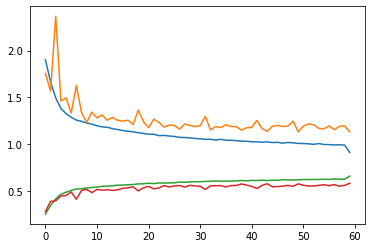

In [29]:
plt.plot(hist), best_acc, curloss

### Resnet50 fintuning

In [5]:
from torchvision import models
rs50 = models.resnet50(pretrained=True)
rs50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
feature_extract = nn.Sequential(
            rs50.conv1, rs50.bn1, rs50.maxpool,
            rs50.layer1,
            rs50.layer2,
            rs50.layer3,
            rs50.layer4)

classifier = nn.Sequential(
                nn.AdaptiveAvgPool2d(output_size=(1,1)),
                nn.Flatten(),
                nn.Linear(2048, 7))
    
feature_extract.requires_grad = True
classifier.requires_grad = True
model = nn.Sequential(feature_extract,
                      classifier)

In [7]:
device = torch.device('cuda')
print(device)

# model = SVGG(device=device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.008
# reduce_factor = 5
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

cuda


In [8]:
model = model.to(device)

# model_folder = '/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention/'
# model_name = 'svgg_resnet4'
# model_path = os.path.join(model_folder, model_name + '.pt')
model_path = './resnet50_finetune_model.pt'

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(300):  # loop over the dataset multiple times
    
#     if (epoch % 60) == 0 and epoch != 0:
#         learning_rate /= reduce_factor
#         print('Decrese learning rate to: ', learning_rate)
#         optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i}  Accuracy={100*running_acc/processed:0.2f}')

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum())
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalcc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / len(val_loader.dataset)):
        best_acc = (running_valacc / len(val_loader.dataset))
        curloss = (running_valloss / len(val_loader.dataset))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.8585792779922485 Batch_id=224  Accuracy=25.03: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]

- Avg.loss: 1.879  | Avg.acc: 0.250



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.789  | Avg. val_acc: 0.272
* Update optimal model
Epoch:  2


Loss=1.5499531030654907 Batch_id=224  Accuracy=38.14: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]

- Avg.loss: 1.581  | Avg.acc: 0.381


- Avg. val_loss: 1.534  | Avg. val_acc: 0.393


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  3


Loss=1.4239022731781006 Batch_id=224  Accuracy=43.85: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s]

- Avg.loss: 1.443  | Avg.acc: 0.438


- Avg. val_loss: 1.437  | Avg. val_acc: 0.428


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  4


Loss=1.4323983192443848 Batch_id=224  Accuracy=46.64: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 1.370  | Avg.acc: 0.466


- Avg. val_loss: 1.390  | Avg. val_acc: 0.456


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  5


Loss=1.2570797204971313 Batch_id=224  Accuracy=48.64: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]

- Avg.loss: 1.329  | Avg.acc: 0.486


- Avg. val_loss: 1.352  | Avg. val_acc: 0.471


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  6


Loss=1.225460410118103 Batch_id=224  Accuracy=49.73: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s] 

- Avg.loss: 1.298  | Avg.acc: 0.497



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.414  | Avg. val_acc: 0.449
Epoch:  7


Loss=0.9623369574546814 Batch_id=224  Accuracy=51.03: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 1.277  | Avg.acc: 0.510


- Avg. val_loss: 1.376  | Avg. val_acc: 0.475


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  8


Loss=1.4067081212997437 Batch_id=224  Accuracy=51.60: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]

- Avg.loss: 1.254  | Avg.acc: 0.516



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.392  | Avg. val_acc: 0.469
Epoch:  9


Loss=1.1555718183517456 Batch_id=224  Accuracy=52.60: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]

- Avg.loss: 1.237  | Avg.acc: 0.526


- Avg. val_loss: 1.368  | Avg. val_acc: 0.476


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  10


Loss=1.5259625911712646 Batch_id=224  Accuracy=53.31: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 1.223  | Avg.acc: 0.533


- Avg. val_loss: 1.303  | Avg. val_acc: 0.497


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  11


Loss=1.0458650588989258 Batch_id=224  Accuracy=53.91: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s]

- Avg.loss: 1.205  | Avg.acc: 0.539


- Avg. val_loss: 1.288  | Avg. val_acc: 0.505


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  12


Loss=1.2029799222946167 Batch_id=224  Accuracy=54.46: 100%|██████████| 225/225 [00:30<00:00,  7.44it/s]

- Avg.loss: 1.186  | Avg.acc: 0.545


- Avg. val_loss: 1.271  | Avg. val_acc: 0.518


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  13


Loss=1.4115756750106812 Batch_id=224  Accuracy=54.85: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 1.179  | Avg.acc: 0.549



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.271  | Avg. val_acc: 0.513
Epoch:  14


Loss=1.205806851387024 Batch_id=224  Accuracy=55.76: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s] 

- Avg.loss: 1.162  | Avg.acc: 0.558



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.307  | Avg. val_acc: 0.507
Epoch:  15


Loss=1.156725525856018 Batch_id=224  Accuracy=55.95: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s] 

- Avg.loss: 1.153  | Avg.acc: 0.559



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.284  | Avg. val_acc: 0.510
Epoch:  16


Loss=1.189096212387085 Batch_id=224  Accuracy=56.47: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 1.145  | Avg.acc: 0.565


- Avg. val_loss: 1.232  | Avg. val_acc: 0.539


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  17


Loss=1.177600383758545 Batch_id=224  Accuracy=56.69: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 1.135  | Avg.acc: 0.567



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.235  | Avg. val_acc: 0.535
Epoch:  18


Loss=1.1365454196929932 Batch_id=224  Accuracy=57.14: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]

- Avg.loss: 1.129  | Avg.acc: 0.571



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.366  | Avg. val_acc: 0.484
Epoch:  19


Loss=1.0703990459442139 Batch_id=224  Accuracy=57.44: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 1.122  | Avg.acc: 0.574



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.234  | Avg. val_acc: 0.539
Epoch:  20


Loss=1.2237385511398315 Batch_id=224  Accuracy=57.58: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s]

- Avg.loss: 1.116  | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.242  | Avg. val_acc: 0.525
Epoch:  21


Loss=1.2050198316574097 Batch_id=224  Accuracy=57.89: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 1.110  | Avg.acc: 0.579



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.227  | Avg. val_acc: 0.531
Epoch:  22


Loss=1.394714593887329 Batch_id=224  Accuracy=57.69: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s] 

- Avg.loss: 1.107  | Avg.acc: 0.577



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.241  | Avg. val_acc: 0.530
Epoch:  23


Loss=1.0326707363128662 Batch_id=224  Accuracy=58.15: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s]

- Avg.loss: 1.101  | Avg.acc: 0.581


- Avg. val_loss: 1.219  | Avg. val_acc: 0.542


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  24


Loss=1.0416511297225952 Batch_id=224  Accuracy=58.32: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s]

- Avg.loss: 1.096  | Avg.acc: 0.583



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.198  | Avg. val_acc: 0.542
Epoch:  25


Loss=1.1349201202392578 Batch_id=224  Accuracy=58.83: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 1.089  | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.203  | Avg. val_acc: 0.542
Epoch:  26


Loss=1.0047032833099365 Batch_id=224  Accuracy=58.66: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 1.083  | Avg.acc: 0.587


- Avg. val_loss: 1.208  | Avg. val_acc: 0.545


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  27


Loss=1.1404285430908203 Batch_id=224  Accuracy=58.70: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 1.082  | Avg.acc: 0.587



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.239  | Avg. val_acc: 0.537
Epoch:  28


Loss=1.4922679662704468 Batch_id=224  Accuracy=59.39: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 1.073  | Avg.acc: 0.594



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.252  | Avg. val_acc: 0.534
Epoch:  29


Loss=1.1887646913528442 Batch_id=224  Accuracy=59.26: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 1.073  | Avg.acc: 0.593


- Avg. val_loss: 1.182  | Avg. val_acc: 0.548


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  30


Loss=1.3208720684051514 Batch_id=224  Accuracy=59.52: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 1.067  | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.225  | Avg. val_acc: 0.544
Epoch:  31


Loss=1.0917154550552368 Batch_id=224  Accuracy=59.62: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 1.066  | Avg.acc: 0.596



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.189  | Avg. val_acc: 0.543
Epoch:  32


Loss=1.072221040725708 Batch_id=224  Accuracy=59.65: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 1.065  | Avg.acc: 0.597


- Avg. val_loss: 1.189  | Avg. val_acc: 0.550


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  33


Loss=1.051876187324524 Batch_id=224  Accuracy=60.31: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s] 

- Avg.loss: 1.054  | Avg.acc: 0.603



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.239  | Avg. val_acc: 0.539
Epoch:  34


Loss=1.1228903532028198 Batch_id=224  Accuracy=59.86: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 1.055  | Avg.acc: 0.599


- Avg. val_loss: 1.186  | Avg. val_acc: 0.555


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  35


Loss=1.2629305124282837 Batch_id=224  Accuracy=60.16: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 1.055  | Avg.acc: 0.602



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.238  | Avg. val_acc: 0.533
Epoch:  36


Loss=0.8321597576141357 Batch_id=224  Accuracy=60.41: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]

- Avg.loss: 1.041  | Avg.acc: 0.604



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.232  | Avg. val_acc: 0.545
Epoch:  37


Loss=1.2481515407562256 Batch_id=224  Accuracy=60.47: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]

- Avg.loss: 1.046  | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.243  | Avg. val_acc: 0.538
Epoch:  38


Loss=1.0550321340560913 Batch_id=224  Accuracy=60.63: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 1.042  | Avg.acc: 0.606


- Avg. val_loss: 1.190  | Avg. val_acc: 0.559
Epoch    38: reducing learning rate of group 0 to 4.0000e-03.


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  39


Loss=1.0847318172454834 Batch_id=224  Accuracy=63.06: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]

- Avg.loss: 0.975  | Avg.acc: 0.631


- Avg. val_loss: 1.147  | Avg. val_acc: 0.573


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  40


Loss=1.2843164205551147 Batch_id=224  Accuracy=64.08: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]

- Avg.loss: 0.951  | Avg.acc: 0.641



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.156  | Avg. val_acc: 0.570
Epoch:  41


Loss=0.6521865725517273 Batch_id=224  Accuracy=64.71: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 0.938  | Avg.acc: 0.647



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.151  | Avg. val_acc: 0.568
Epoch:  42


Loss=1.0139811038970947 Batch_id=224  Accuracy=65.00: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.933  | Avg.acc: 0.650


- Avg. val_loss: 1.136  | Avg. val_acc: 0.577


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  43


Loss=1.1316044330596924 Batch_id=224  Accuracy=64.83: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]

- Avg.loss: 0.931  | Avg.acc: 0.648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.137  | Avg. val_acc: 0.577
Epoch:  44


Loss=0.8402457237243652 Batch_id=224  Accuracy=65.35: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 0.922  | Avg.acc: 0.653



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.176  | Avg. val_acc: 0.564
Epoch:  45


Loss=1.0137618780136108 Batch_id=224  Accuracy=66.09: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s]

- Avg.loss: 0.909  | Avg.acc: 0.661



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.172  | Avg. val_acc: 0.567
Epoch:  46


Loss=0.9224616289138794 Batch_id=224  Accuracy=65.86: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 0.904  | Avg.acc: 0.659


- Avg. val_loss: 1.134  | Avg. val_acc: 0.581


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  47


Loss=0.8854450583457947 Batch_id=224  Accuracy=66.16: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]

- Avg.loss: 0.903  | Avg.acc: 0.662



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.155  | Avg. val_acc: 0.575
Epoch:  48


Loss=0.7081884741783142 Batch_id=224  Accuracy=66.09: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 0.896  | Avg.acc: 0.661


- Avg. val_loss: 1.146  | Avg. val_acc: 0.584


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  49


Loss=0.7125884890556335 Batch_id=224  Accuracy=66.43: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s]

- Avg.loss: 0.893  | Avg.acc: 0.664



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.145  | Avg. val_acc: 0.573
Epoch:  50


Loss=0.9226784706115723 Batch_id=224  Accuracy=66.56: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s]

- Avg.loss: 0.888  | Avg.acc: 0.666



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.151  | Avg. val_acc: 0.573
Epoch:  51


Loss=0.7779024839401245 Batch_id=224  Accuracy=66.71: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.886  | Avg.acc: 0.667



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.152  | Avg. val_acc: 0.566
Epoch:  52


Loss=1.2579556703567505 Batch_id=224  Accuracy=66.75: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.882  | Avg.acc: 0.667



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.171  | Avg. val_acc: 0.571
Epoch:  53


Loss=0.6374799609184265 Batch_id=224  Accuracy=67.25: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.870  | Avg.acc: 0.673



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.162  | Avg. val_acc: 0.574
Epoch:  54


Loss=1.0356369018554688 Batch_id=224  Accuracy=67.31: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 0.868  | Avg.acc: 0.673



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.192  | Avg. val_acc: 0.570
Epoch:  55


Loss=1.0388433933258057 Batch_id=224  Accuracy=67.07: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]

- Avg.loss: 0.868  | Avg.acc: 0.671



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.184  | Avg. val_acc: 0.573
Epoch    55: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  56


Loss=0.872229278087616 Batch_id=224  Accuracy=70.02: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s] 

- Avg.loss: 0.802  | Avg.acc: 0.700


- Avg. val_loss: 1.149  | Avg. val_acc: 0.588


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  57


Loss=0.841020405292511 Batch_id=224  Accuracy=71.10: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s] 

- Avg.loss: 0.776  | Avg.acc: 0.711



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.181  | Avg. val_acc: 0.588
Epoch:  58


Loss=0.8639727830886841 Batch_id=224  Accuracy=71.63: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s]

- Avg.loss: 0.756  | Avg.acc: 0.716



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.214  | Avg. val_acc: 0.579
Epoch:  59


Loss=0.8502451181411743 Batch_id=224  Accuracy=72.14: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 0.749  | Avg.acc: 0.721



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.187  | Avg. val_acc: 0.583
Epoch:  60


Loss=0.8364603519439697 Batch_id=224  Accuracy=72.01: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 0.749  | Avg.acc: 0.720



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.181  | Avg. val_acc: 0.588
Epoch:  61


Loss=0.7826137542724609 Batch_id=224  Accuracy=72.94: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s]

- Avg.loss: 0.735  | Avg.acc: 0.729



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.201  | Avg. val_acc: 0.583
Epoch:  62


Loss=0.8054190874099731 Batch_id=224  Accuracy=73.12: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]

- Avg.loss: 0.726  | Avg.acc: 0.731



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.222  | Avg. val_acc: 0.579
Epoch:  63


Loss=0.8029128313064575 Batch_id=224  Accuracy=73.25: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.717  | Avg.acc: 0.732



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.196  | Avg. val_acc: 0.583
Epoch:  64


Loss=0.48844486474990845 Batch_id=224  Accuracy=73.36: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]

- Avg.loss: 0.716  | Avg.acc: 0.734



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.224  | Avg. val_acc: 0.581
Epoch    64: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  65


Loss=0.8903955817222595 Batch_id=224  Accuracy=75.83: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s] 

- Avg.loss: 0.660  | Avg.acc: 0.758



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.225  | Avg. val_acc: 0.588
Epoch:  66


Loss=0.7789719104766846 Batch_id=224  Accuracy=76.95: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 0.632  | Avg.acc: 0.769



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.258  | Avg. val_acc: 0.583
Epoch:  67


Loss=0.7712615132331848 Batch_id=224  Accuracy=77.14: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 0.619  | Avg.acc: 0.771



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.296  | Avg. val_acc: 0.577
Epoch:  68


Loss=0.5518047213554382 Batch_id=224  Accuracy=77.70: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s] 

- Avg.loss: 0.611  | Avg.acc: 0.777



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.289  | Avg. val_acc: 0.583
Epoch:  69


Loss=0.8150121569633484 Batch_id=224  Accuracy=77.82: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s] 

- Avg.loss: 0.606  | Avg.acc: 0.778



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.288  | Avg. val_acc: 0.583
Epoch:  70


Loss=0.9790869951248169 Batch_id=224  Accuracy=77.86: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 0.601  | Avg.acc: 0.779



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.304  | Avg. val_acc: 0.587
Epoch:  71


Loss=0.7973806262016296 Batch_id=224  Accuracy=78.21: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 0.594  | Avg.acc: 0.782



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.324  | Avg. val_acc: 0.581
Epoch:  72


Loss=0.30951160192489624 Batch_id=224  Accuracy=78.75: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s]

- Avg.loss: 0.580  | Avg.acc: 0.787



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.342  | Avg. val_acc: 0.581
Epoch:  73


Loss=0.6456705927848816 Batch_id=224  Accuracy=79.11: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 0.572  | Avg.acc: 0.791



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.360  | Avg. val_acc: 0.578
Epoch    73: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  74


Loss=0.3723412752151489 Batch_id=224  Accuracy=80.73: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s] 

- Avg.loss: 0.534  | Avg.acc: 0.807



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.360  | Avg. val_acc: 0.585
Epoch:  75


Loss=0.5225507616996765 Batch_id=224  Accuracy=81.47: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s] 

- Avg.loss: 0.517  | Avg.acc: 0.815


- Avg. val_loss: 1.382  | Avg. val_acc: 0.589


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  76


Loss=0.5497214794158936 Batch_id=224  Accuracy=81.40: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s] 

- Avg.loss: 0.518  | Avg.acc: 0.814



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.406  | Avg. val_acc: 0.587
Epoch:  77


Loss=0.44244512915611267 Batch_id=224  Accuracy=81.98: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.507  | Avg.acc: 0.820



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.417  | Avg. val_acc: 0.579
Epoch:  78


Loss=0.41786691546440125 Batch_id=224  Accuracy=82.24: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 0.495  | Avg.acc: 0.822



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.434  | Avg. val_acc: 0.582
Epoch:  79


Loss=0.4735444486141205 Batch_id=224  Accuracy=82.25: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s] 

- Avg.loss: 0.496  | Avg.acc: 0.822



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.434  | Avg. val_acc: 0.585
Epoch:  80


Loss=0.8385319113731384 Batch_id=224  Accuracy=82.51: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s] 

- Avg.loss: 0.485  | Avg.acc: 0.825


- Avg. val_loss: 1.460  | Avg. val_acc: 0.589


  0%|          | 0/225 [00:00<?, ?it/s]

* Update optimal model
Epoch:  81


Loss=0.3343004882335663 Batch_id=224  Accuracy=82.63: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 0.483  | Avg.acc: 0.826



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.483  | Avg. val_acc: 0.583
Epoch:  82


Loss=0.43294087052345276 Batch_id=224  Accuracy=82.95: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 0.474  | Avg.acc: 0.830



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.486  | Avg. val_acc: 0.586
Epoch    82: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  83


Loss=0.3815823197364807 Batch_id=224  Accuracy=84.04: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s] 

- Avg.loss: 0.452  | Avg.acc: 0.840



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.473  | Avg. val_acc: 0.589
Epoch:  84


Loss=0.4973877966403961 Batch_id=224  Accuracy=84.68: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s] 

- Avg.loss: 0.442  | Avg.acc: 0.847



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.493  | Avg. val_acc: 0.583
Epoch:  85


Loss=0.38682371377944946 Batch_id=224  Accuracy=84.57: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 0.439  | Avg.acc: 0.846



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.521  | Avg. val_acc: 0.584
Epoch:  86


Loss=0.6019470691680908 Batch_id=224  Accuracy=84.75: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 0.436  | Avg.acc: 0.848



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.522  | Avg. val_acc: 0.583
Epoch:  87


Loss=0.2933753430843353 Batch_id=224  Accuracy=84.67: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s] 

- Avg.loss: 0.432  | Avg.acc: 0.847



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.533  | Avg. val_acc: 0.585
Epoch:  88


Loss=0.32586243748664856 Batch_id=224  Accuracy=85.03: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 0.426  | Avg.acc: 0.850



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.554  | Avg. val_acc: 0.588
Epoch:  89


Loss=0.6500952839851379 Batch_id=224  Accuracy=85.17: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 0.422  | Avg.acc: 0.852



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.564  | Avg. val_acc: 0.587
Epoch:  90


Loss=0.4864410161972046 Batch_id=224  Accuracy=85.40: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s] 

- Avg.loss: 0.420  | Avg.acc: 0.854



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.571  | Avg. val_acc: 0.585
Epoch:  91


Loss=0.40440094470977783 Batch_id=224  Accuracy=85.55: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 0.415  | Avg.acc: 0.856



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.597  | Avg. val_acc: 0.584
Epoch    91: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  92


Loss=0.4881114363670349 Batch_id=224  Accuracy=85.91: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s] 

- Avg.loss: 0.406  | Avg.acc: 0.859



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.586  | Avg. val_acc: 0.585
Epoch:  93


Loss=0.6121731996536255 Batch_id=224  Accuracy=86.14: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s] 

- Avg.loss: 0.401  | Avg.acc: 0.861



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.600  | Avg. val_acc: 0.588
Epoch:  94


Loss=0.5887037515640259 Batch_id=224  Accuracy=86.40: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s] 

- Avg.loss: 0.397  | Avg.acc: 0.864



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.599  | Avg. val_acc: 0.585
Epoch:  95


Loss=0.2929028570652008 Batch_id=224  Accuracy=86.38: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s] 

- Avg.loss: 0.392  | Avg.acc: 0.864



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.616  | Avg. val_acc: 0.584
Epoch:  96


Loss=0.3677968680858612 Batch_id=224  Accuracy=86.34: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s] 

- Avg.loss: 0.392  | Avg.acc: 0.863



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.622  | Avg. val_acc: 0.585
Epoch:  97


Loss=0.7901958227157593 Batch_id=224  Accuracy=86.63: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 0.388  | Avg.acc: 0.866



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.634  | Avg. val_acc: 0.584
Epoch:  98


Loss=0.2925349771976471 Batch_id=224  Accuracy=86.56: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 0.389  | Avg.acc: 0.866



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.633  | Avg. val_acc: 0.584
Epoch:  99


Loss=0.4918307662010193 Batch_id=224  Accuracy=86.56: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s] 

- Avg.loss: 0.387  | Avg.acc: 0.866



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.642  | Avg. val_acc: 0.585
Epoch:  100


Loss=0.5272244811058044 Batch_id=224  Accuracy=86.41: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s] 

- Avg.loss: 0.387  | Avg.acc: 0.864



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.644  | Avg. val_acc: 0.580
Epoch   100: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  101


Loss=0.17241311073303223 Batch_id=224  Accuracy=86.83: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.380  | Avg.acc: 0.868



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.645  | Avg. val_acc: 0.588
Epoch:  102


Loss=0.5174663066864014 Batch_id=224  Accuracy=86.96: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s] 

- Avg.loss: 0.377  | Avg.acc: 0.870



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.637  | Avg. val_acc: 0.587
Epoch:  103


Loss=0.44128870964050293 Batch_id=224  Accuracy=87.13: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 0.373  | Avg.acc: 0.871



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.665  | Avg. val_acc: 0.584
Epoch:  104


Loss=0.6217565536499023 Batch_id=224  Accuracy=87.27: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s] 

- Avg.loss: 0.372  | Avg.acc: 0.873



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.668  | Avg. val_acc: 0.582
Epoch:  105


Loss=0.4189397692680359 Batch_id=224  Accuracy=87.15: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s] 

- Avg.loss: 0.371  | Avg.acc: 0.872



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.668  | Avg. val_acc: 0.584
Epoch:  106


Loss=0.29527559876441956 Batch_id=224  Accuracy=87.43: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]

- Avg.loss: 0.371  | Avg.acc: 0.874



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.664  | Avg. val_acc: 0.585
Epoch:  107


Loss=0.34434664249420166 Batch_id=224  Accuracy=87.42: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]

- Avg.loss: 0.371  | Avg.acc: 0.874



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.690  | Avg. val_acc: 0.585
Epoch:  108


Loss=0.32017531991004944 Batch_id=224  Accuracy=87.55: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s]

- Avg.loss: 0.364  | Avg.acc: 0.875



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.690  | Avg. val_acc: 0.586
Epoch:  109


Loss=0.5670190453529358 Batch_id=224  Accuracy=87.32: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s] 

- Avg.loss: 0.368  | Avg.acc: 0.873



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.697  | Avg. val_acc: 0.582
Epoch   109: reducing learning rate of group 0 to 3.1250e-05.
Epoch:  110


Loss=0.22185282409191132 Batch_id=224  Accuracy=87.80: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.360  | Avg.acc: 0.878



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.699  | Avg. val_acc: 0.584
Epoch:  111


Loss=0.6644117832183838 Batch_id=224  Accuracy=87.86: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 0.358  | Avg.acc: 0.879



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.683  | Avg. val_acc: 0.582
Epoch:  112


Loss=0.28224560618400574 Batch_id=224  Accuracy=87.74: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 0.361  | Avg.acc: 0.877



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.698  | Avg. val_acc: 0.586
Epoch:  113


Loss=0.35201573371887207 Batch_id=224  Accuracy=87.89: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.357  | Avg.acc: 0.879



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.695  | Avg. val_acc: 0.583
Epoch:  114


Loss=0.34193968772888184 Batch_id=224  Accuracy=87.71: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 0.361  | Avg.acc: 0.877



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.687  | Avg. val_acc: 0.583
Epoch:  115


Loss=0.46416932344436646 Batch_id=224  Accuracy=87.73: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]

- Avg.loss: 0.355  | Avg.acc: 0.877



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.690  | Avg. val_acc: 0.585
Epoch:  116


Loss=0.2099922150373459 Batch_id=224  Accuracy=87.70: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s] 

- Avg.loss: 0.360  | Avg.acc: 0.877



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.701  | Avg. val_acc: 0.585
Epoch:  117


Loss=0.46359866857528687 Batch_id=224  Accuracy=87.68: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]

- Avg.loss: 0.362  | Avg.acc: 0.877



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.719  | Avg. val_acc: 0.582
Epoch:  118


Loss=0.5117774605751038 Batch_id=224  Accuracy=87.91: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s] 

- Avg.loss: 0.357  | Avg.acc: 0.879



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.710  | Avg. val_acc: 0.584
Epoch   118: reducing learning rate of group 0 to 1.5625e-05.
Epoch:  119


Loss=0.5507659912109375 Batch_id=224  Accuracy=87.83: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s] 

- Avg.loss: 0.356  | Avg.acc: 0.878



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.710  | Avg. val_acc: 0.584
Epoch:  120


Loss=0.3425179421901703 Batch_id=224  Accuracy=87.88: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s] 

- Avg.loss: 0.356  | Avg.acc: 0.879



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.714  | Avg. val_acc: 0.583
Epoch:  121


Loss=0.321296364068985 Batch_id=224  Accuracy=87.93: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]  

- Avg.loss: 0.354  | Avg.acc: 0.879



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.713  | Avg. val_acc: 0.584
Epoch:  122


Loss=0.27685418725013733 Batch_id=224  Accuracy=87.86: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 0.354  | Avg.acc: 0.879



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.700  | Avg. val_acc: 0.581
Epoch:  123


Loss=0.42124149203300476 Batch_id=224  Accuracy=87.96: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 0.353  | Avg.acc: 0.880



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.723  | Avg. val_acc: 0.584
Epoch:  124


Loss=0.37632638216018677 Batch_id=224  Accuracy=87.83: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.357  | Avg.acc: 0.878



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.719  | Avg. val_acc: 0.584
Epoch:  125


Loss=0.504230260848999 Batch_id=224  Accuracy=87.87: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s]  

- Avg.loss: 0.354  | Avg.acc: 0.879



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.711  | Avg. val_acc: 0.581
Epoch:  126


Loss=0.3214736878871918 Batch_id=224  Accuracy=87.87: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 0.358  | Avg.acc: 0.879



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.713  | Avg. val_acc: 0.581
Epoch:  127


Loss=0.4376332461833954 Batch_id=224  Accuracy=87.90: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 0.353  | Avg.acc: 0.879



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.709  | Avg. val_acc: 0.583
Epoch   127: reducing learning rate of group 0 to 7.8125e-06.
Epoch:  128


Loss=0.46209031343460083 Batch_id=224  Accuracy=88.09: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s]

- Avg.loss: 0.352  | Avg.acc: 0.881



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.730  | Avg. val_acc: 0.582
Epoch:  129


Loss=0.381449818611145 Batch_id=224  Accuracy=87.92: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]  

- Avg.loss: 0.353  | Avg.acc: 0.879



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.715  | Avg. val_acc: 0.583
Epoch:  130


Loss=0.4090494215488434 Batch_id=224  Accuracy=87.97: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s] 

- Avg.loss: 0.351  | Avg.acc: 0.880



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.711  | Avg. val_acc: 0.584
Epoch:  131


Loss=0.4753987491130829 Batch_id=224  Accuracy=88.10: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 0.352  | Avg.acc: 0.881



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.714  | Avg. val_acc: 0.584
Epoch:  132


Loss=0.42209291458129883 Batch_id=224  Accuracy=88.01: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]

- Avg.loss: 0.350  | Avg.acc: 0.880



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.720  | Avg. val_acc: 0.584
Epoch:  133


Loss=0.5035930275917053 Batch_id=224  Accuracy=88.03: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s] 

- Avg.loss: 0.349  | Avg.acc: 0.880



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.726  | Avg. val_acc: 0.581
Epoch:  134


Loss=0.3896694779396057 Batch_id=224  Accuracy=88.34: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s] 

- Avg.loss: 0.348  | Avg.acc: 0.883



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.727  | Avg. val_acc: 0.585
Epoch:  135


Loss=0.35736745595932007 Batch_id=224  Accuracy=88.27: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.348  | Avg.acc: 0.883



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.713  | Avg. val_acc: 0.583
Epoch:  136


Loss=0.5625022053718567 Batch_id=224  Accuracy=87.93: 100%|██████████| 225/225 [00:29<00:00,  7.56it/s] 

- Avg.loss: 0.351  | Avg.acc: 0.879



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.730  | Avg. val_acc: 0.584
Epoch   136: reducing learning rate of group 0 to 3.9063e-06.
Epoch:  137


Loss=0.2145845592021942 Batch_id=224  Accuracy=88.24: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s] 

- Avg.loss: 0.348  | Avg.acc: 0.882



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.725  | Avg. val_acc: 0.578
Epoch:  138


Loss=0.36239442229270935 Batch_id=224  Accuracy=88.35: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 0.344  | Avg.acc: 0.884



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.724  | Avg. val_acc: 0.584
Epoch:  139


Loss=0.38745272159576416 Batch_id=224  Accuracy=88.05: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]

- Avg.loss: 0.349  | Avg.acc: 0.880



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.734  | Avg. val_acc: 0.580
Epoch:  140


Loss=0.4461272060871124 Batch_id=224  Accuracy=88.16: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 0.351  | Avg.acc: 0.882



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.736  | Avg. val_acc: 0.584
Epoch:  141


Loss=0.44906148314476013 Batch_id=224  Accuracy=88.27: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.347  | Avg.acc: 0.883



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.723  | Avg. val_acc: 0.584
Epoch:  142


Loss=0.3325352072715759 Batch_id=224  Accuracy=88.04: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s] 

- Avg.loss: 0.352  | Avg.acc: 0.880



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.727  | Avg. val_acc: 0.583
Epoch:  143


Loss=0.28411588072776794 Batch_id=224  Accuracy=88.13: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 0.349  | Avg.acc: 0.881



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.733  | Avg. val_acc: 0.581
Epoch:  144


Loss=0.41793394088745117 Batch_id=224  Accuracy=88.14: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 0.348  | Avg.acc: 0.881



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.716  | Avg. val_acc: 0.584
Epoch:  145


Loss=0.25910326838493347 Batch_id=224  Accuracy=88.39: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 0.344  | Avg.acc: 0.884



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.714  | Avg. val_acc: 0.581
Epoch   145: reducing learning rate of group 0 to 1.9531e-06.
Epoch:  146


Loss=0.4392305910587311 Batch_id=224  Accuracy=88.10: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s] 

- Avg.loss: 0.347  | Avg.acc: 0.881



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.731  | Avg. val_acc: 0.586
Epoch:  147


Loss=0.6402902007102966 Batch_id=224  Accuracy=88.27: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s] 

- Avg.loss: 0.351  | Avg.acc: 0.883



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.726  | Avg. val_acc: 0.582
Epoch:  148


Loss=0.32844674587249756 Batch_id=224  Accuracy=88.01: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]

- Avg.loss: 0.351  | Avg.acc: 0.880



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.726  | Avg. val_acc: 0.583
Epoch:  149


Loss=0.3477616310119629 Batch_id=224  Accuracy=88.30: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s] 

- Avg.loss: 0.345  | Avg.acc: 0.883



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.716  | Avg. val_acc: 0.584
Epoch:  150


Loss=0.5246850848197937 Batch_id=224  Accuracy=88.17: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s] 

- Avg.loss: 0.348  | Avg.acc: 0.882



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.733  | Avg. val_acc: 0.582
Epoch:  151


Loss=0.35230275988578796 Batch_id=224  Accuracy=88.06: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 0.350  | Avg.acc: 0.881



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.730  | Avg. val_acc: 0.582
Epoch:  152


Loss=0.4058225154876709 Batch_id=224  Accuracy=88.22: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 0.347  | Avg.acc: 0.882



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.728  | Avg. val_acc: 0.581
Epoch:  153


Loss=0.6518823504447937 Batch_id=224  Accuracy=88.35: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s] 

- Avg.loss: 0.349  | Avg.acc: 0.884



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.732  | Avg. val_acc: 0.584
Epoch:  154


Loss=0.3520852327346802 Batch_id=224  Accuracy=88.33: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s] 

- Avg.loss: 0.346  | Avg.acc: 0.883



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.733  | Avg. val_acc: 0.583
Epoch   154: reducing learning rate of group 0 to 9.7656e-07.
Epoch:  155


Loss=0.3351903557777405 Batch_id=224  Accuracy=88.08: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s] 

- Avg.loss: 0.349  | Avg.acc: 0.881



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.731  | Avg. val_acc: 0.585
Epoch:  156


Loss=0.2523297965526581 Batch_id=224  Accuracy=88.09: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s] 

- Avg.loss: 0.350  | Avg.acc: 0.881



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.723  | Avg. val_acc: 0.582
Epoch:  157


Loss=0.330956369638443 Batch_id=224  Accuracy=88.13: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]  

- Avg.loss: 0.347  | Avg.acc: 0.881



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.716  | Avg. val_acc: 0.582
Epoch:  158


Loss=0.3268444836139679 Batch_id=224  Accuracy=88.31: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s] 

- Avg.loss: 0.345  | Avg.acc: 0.883



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.728  | Avg. val_acc: 0.583
Epoch:  159


Loss=0.18361039459705353 Batch_id=224  Accuracy=88.11: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 0.347  | Avg.acc: 0.881



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.733  | Avg. val_acc: 0.580
Epoch:  160


Loss=0.2664671838283539 Batch_id=224  Accuracy=88.25: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s] 

- Avg.loss: 0.347  | Avg.acc: 0.883



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.723  | Avg. val_acc: 0.583
Epoch:  161


Loss=0.5447565317153931 Batch_id=224  Accuracy=88.02: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s] 

- Avg.loss: 0.349  | Avg.acc: 0.880



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.725  | Avg. val_acc: 0.582
Epoch:  162


Loss=0.4226086437702179 Batch_id=224  Accuracy=88.16: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s] 

- Avg.loss: 0.351  | Avg.acc: 0.882



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.727  | Avg. val_acc: 0.579
Epoch:  163


Loss=0.5966550707817078 Batch_id=224  Accuracy=88.12: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s] 

- Avg.loss: 0.351  | Avg.acc: 0.881



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.722  | Avg. val_acc: 0.582
Epoch   163: reducing learning rate of group 0 to 4.8828e-07.
Epoch:  164


Loss=0.6156770586967468 Batch_id=224  Accuracy=88.29: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s] 

- Avg.loss: 0.350  | Avg.acc: 0.883



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.728  | Avg. val_acc: 0.584
Epoch:  165


Loss=0.6193939447402954 Batch_id=224  Accuracy=88.06: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s] 

- Avg.loss: 0.351  | Avg.acc: 0.881



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.729  | Avg. val_acc: 0.583
Epoch:  166


Loss=0.7145928144454956 Batch_id=224  Accuracy=88.07: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s] 

- Avg.loss: 0.347  | Avg.acc: 0.881



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.725  | Avg. val_acc: 0.583
Epoch:  167


Loss=0.46809718012809753 Batch_id=224  Accuracy=88.22: 100%|██████████| 225/225 [00:30<00:00,  7.43it/s]

- Avg.loss: 0.347  | Avg.acc: 0.882



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.729  | Avg. val_acc: 0.581
Epoch:  168


Loss=0.5020533800125122 Batch_id=224  Accuracy=88.12: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s] 

- Avg.loss: 0.346  | Avg.acc: 0.881



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.727  | Avg. val_acc: 0.582
Epoch:  169


Loss=0.534117579460144 Batch_id=224  Accuracy=88.35: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s]  

- Avg.loss: 0.349  | Avg.acc: 0.883



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.724  | Avg. val_acc: 0.583
Epoch:  170


Loss=0.32843002676963806 Batch_id=224  Accuracy=88.32: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]

- Avg.loss: 0.349  | Avg.acc: 0.883



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.714  | Avg. val_acc: 0.585
Epoch:  171


Loss=0.42063820362091064 Batch_id=224  Accuracy=88.16: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 0.351  | Avg.acc: 0.882



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.725  | Avg. val_acc: 0.581
Epoch:  172


Loss=0.7291862368583679 Batch_id=224  Accuracy=88.12: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s] 

- Avg.loss: 0.348  | Avg.acc: 0.881



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.723  | Avg. val_acc: 0.586
Epoch   172: reducing learning rate of group 0 to 2.4414e-07.
Epoch:  173


Loss=0.4263667166233063 Batch_id=224  Accuracy=88.15: 100%|██████████| 225/225 [00:29<00:00,  7.55it/s] 

- Avg.loss: 0.349  | Avg.acc: 0.882



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.729  | Avg. val_acc: 0.583
Epoch:  174


Loss=0.24956290423870087 Batch_id=224  Accuracy=88.22: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.348  | Avg.acc: 0.882



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.718  | Avg. val_acc: 0.583
Epoch:  175


Loss=0.32100996375083923 Batch_id=224  Accuracy=88.51: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 0.341  | Avg.acc: 0.885



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.724  | Avg. val_acc: 0.584
Epoch:  176


Loss=0.3526184558868408 Batch_id=224  Accuracy=88.05: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s] 

- Avg.loss: 0.351  | Avg.acc: 0.880



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.734  | Avg. val_acc: 0.583
Epoch:  177


Loss=0.6971467733383179 Batch_id=224  Accuracy=88.04: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s] 

- Avg.loss: 0.351  | Avg.acc: 0.880



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.728  | Avg. val_acc: 0.585
Epoch:  178


Loss=0.46086835861206055 Batch_id=224  Accuracy=88.52: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.343  | Avg.acc: 0.885



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.725  | Avg. val_acc: 0.586
Epoch:  179


Loss=0.3634234368801117 Batch_id=224  Accuracy=88.47: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s] 

- Avg.loss: 0.344  | Avg.acc: 0.885



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.716  | Avg. val_acc: 0.584
Epoch:  180


Loss=0.5448582768440247 Batch_id=224  Accuracy=88.26: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s] 

- Avg.loss: 0.348  | Avg.acc: 0.883



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.729  | Avg. val_acc: 0.581
Epoch:  181


Loss=0.5230008959770203 Batch_id=224  Accuracy=88.23: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s] 

- Avg.loss: 0.347  | Avg.acc: 0.882



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.724  | Avg. val_acc: 0.584
Epoch   181: reducing learning rate of group 0 to 1.2207e-07.
Epoch:  182


Loss=0.6339018940925598 Batch_id=224  Accuracy=88.30: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s] 

- Avg.loss: 0.346  | Avg.acc: 0.883



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.722  | Avg. val_acc: 0.583
Epoch:  183


Loss=0.3824443817138672 Batch_id=224  Accuracy=88.19: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 0.345  | Avg.acc: 0.882



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.733  | Avg. val_acc: 0.580
Epoch:  184


Loss=0.4552813768386841 Batch_id=224  Accuracy=88.36: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s] 

- Avg.loss: 0.348  | Avg.acc: 0.884



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.722  | Avg. val_acc: 0.581
Epoch:  185


Loss=0.3894346356391907 Batch_id=224  Accuracy=88.29: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s] 

- Avg.loss: 0.348  | Avg.acc: 0.883



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.710  | Avg. val_acc: 0.585
Epoch:  186


Loss=0.3194323182106018 Batch_id=224  Accuracy=88.09: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s] 

- Avg.loss: 0.353  | Avg.acc: 0.881



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.734  | Avg. val_acc: 0.581
Epoch:  187


Loss=0.6977788805961609 Batch_id=224  Accuracy=88.25: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 0.347  | Avg.acc: 0.882



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.727  | Avg. val_acc: 0.580
Epoch:  188


Loss=0.23466001451015472 Batch_id=224  Accuracy=88.13: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]

- Avg.loss: 0.350  | Avg.acc: 0.881



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.724  | Avg. val_acc: 0.583
Epoch:  189


Loss=0.664422333240509 Batch_id=224  Accuracy=88.24: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]  

- Avg.loss: 0.350  | Avg.acc: 0.882



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.740  | Avg. val_acc: 0.580
Epoch:  190


Loss=0.23315471410751343 Batch_id=224  Accuracy=88.20: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]

- Avg.loss: 0.347  | Avg.acc: 0.882



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.727  | Avg. val_acc: 0.581
Epoch   190: reducing learning rate of group 0 to 6.1035e-08.
Epoch:  191


Loss=0.31206488609313965 Batch_id=224  Accuracy=88.12: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s]

- Avg.loss: 0.347  | Avg.acc: 0.881



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.725  | Avg. val_acc: 0.581
Epoch:  192


Loss=0.5340151786804199 Batch_id=0  Accuracy=80.47:   0%|          | 1/225 [00:00<01:44,  2.14it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.6896982192993164 Batch_id=224  Accuracy=88.12: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s] 

- Avg.loss: 0.352  | Avg.acc: 0.881



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.712  | Avg. val_acc: 0.585
Epoch:  211


Loss=0.31841152906417847 Batch_id=224  Accuracy=88.11: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]

- Avg.loss: 0.346  | Avg.acc: 0.881



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.717  | Avg. val_acc: 0.585
Epoch:  212


Loss=0.4876759946346283 Batch_id=224  Accuracy=88.13: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s] 

- Avg.loss: 0.349  | Avg.acc: 0.881



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.731  | Avg. val_acc: 0.585
Epoch:  213


Loss=0.621518611907959 Batch_id=224  Accuracy=88.21: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s]  

- Avg.loss: 0.345  | Avg.acc: 0.882



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.709  | Avg. val_acc: 0.585
Epoch:  214


Loss=0.623573899269104 Batch_id=224  Accuracy=88.03: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s]  

- Avg.loss: 0.350  | Avg.acc: 0.880



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.718  | Avg. val_acc: 0.583
Epoch:  215


Loss=0.2674471139907837 Batch_id=224  Accuracy=88.29: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s] 

- Avg.loss: 0.345  | Avg.acc: 0.883



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.727  | Avg. val_acc: 0.582
Epoch:  216


Loss=0.2550027668476105 Batch_id=172  Accuracy=88.26:  77%|███████▋  | 173/225 [00:23<00:06,  7.59it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.2594323754310608 Batch_id=224  Accuracy=88.21: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 0.347  | Avg.acc: 0.882



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.727  | Avg. val_acc: 0.582
Epoch:  235


Loss=0.45913419127464294 Batch_id=224  Accuracy=88.23: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]

- Avg.loss: 0.346  | Avg.acc: 0.882



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.722  | Avg. val_acc: 0.583
Epoch:  236


Loss=0.5046390295028687 Batch_id=224  Accuracy=88.15: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 0.348  | Avg.acc: 0.882



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.735  | Avg. val_acc: 0.585
Epoch:  237


Loss=0.5925303101539612 Batch_id=224  Accuracy=88.19: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s] 

- Avg.loss: 0.347  | Avg.acc: 0.882



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.726  | Avg. val_acc: 0.582
Epoch:  238


Loss=0.23013637959957123 Batch_id=224  Accuracy=88.27: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 0.349  | Avg.acc: 0.883



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.739  | Avg. val_acc: 0.581
Epoch:  239


Loss=0.31921425461769104 Batch_id=224  Accuracy=88.32: 100%|██████████| 225/225 [00:29<00:00,  7.52it/s]

- Avg.loss: 0.344  | Avg.acc: 0.883



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.719  | Avg. val_acc: 0.584
Epoch:  240


Loss=0.3001622259616852 Batch_id=224  Accuracy=88.23: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 0.348  | Avg.acc: 0.882



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.726  | Avg. val_acc: 0.583
Epoch:  241


Loss=0.5016877055168152 Batch_id=82  Accuracy=88.51:  37%|███▋      | 83/225 [00:11<00:18,  7.62it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.49104994535446167 Batch_id=224  Accuracy=88.25: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s]

- Avg.loss: 0.347  | Avg.acc: 0.882



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.731  | Avg. val_acc: 0.583
Epoch:  260


Loss=0.23289942741394043 Batch_id=224  Accuracy=88.22: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]

- Avg.loss: 0.347  | Avg.acc: 0.882



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.726  | Avg. val_acc: 0.584
Epoch:  261


Loss=0.6157916784286499 Batch_id=224  Accuracy=88.36: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s] 

- Avg.loss: 0.347  | Avg.acc: 0.884



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.730  | Avg. val_acc: 0.581
Epoch:  262


Loss=0.42654964327812195 Batch_id=224  Accuracy=88.28: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s]

- Avg.loss: 0.346  | Avg.acc: 0.883



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.728  | Avg. val_acc: 0.584
Epoch:  263


Loss=0.49442172050476074 Batch_id=224  Accuracy=88.30: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 0.344  | Avg.acc: 0.883



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.724  | Avg. val_acc: 0.583
Epoch:  264


Loss=0.24631768465042114 Batch_id=224  Accuracy=88.45: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]

- Avg.loss: 0.343  | Avg.acc: 0.884



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.732  | Avg. val_acc: 0.581
Epoch:  265


Loss=0.33058634400367737 Batch_id=224  Accuracy=88.26: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 0.343  | Avg.acc: 0.883



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.736  | Avg. val_acc: 0.583
Epoch:  266


Loss=0.39152011275291443 Batch_id=32  Accuracy=87.93:  14%|█▍        | 32/225 [00:04<00:25,  7.64it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.5319747924804688 Batch_id=224  Accuracy=88.15: 100%|██████████| 225/225 [00:29<00:00,  7.53it/s] 

- Avg.loss: 0.349  | Avg.acc: 0.882



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.729  | Avg. val_acc: 0.581
Epoch:  285


Loss=0.20369932055473328 Batch_id=224  Accuracy=87.98: 100%|██████████| 225/225 [00:29<00:00,  7.50it/s]

- Avg.loss: 0.352  | Avg.acc: 0.880



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.726  | Avg. val_acc: 0.585
Epoch:  286


Loss=0.38616079092025757 Batch_id=224  Accuracy=88.45: 100%|██████████| 225/225 [00:29<00:00,  7.51it/s]

- Avg.loss: 0.347  | Avg.acc: 0.885



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.717  | Avg. val_acc: 0.583
Epoch:  287


Loss=0.3462136387825012 Batch_id=224  Accuracy=88.36: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 0.347  | Avg.acc: 0.884



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.724  | Avg. val_acc: 0.583
Epoch:  288


Loss=0.5771116614341736 Batch_id=224  Accuracy=88.01: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s] 

- Avg.loss: 0.351  | Avg.acc: 0.880



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.726  | Avg. val_acc: 0.583
Epoch:  289


Loss=0.7452782392501831 Batch_id=224  Accuracy=88.17: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 0.350  | Avg.acc: 0.882



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.735  | Avg. val_acc: 0.583
Epoch:  290


Loss=0.32900723814964294 Batch_id=190  Accuracy=88.00:  84%|████████▍ | 190/225 [00:25<00:04,  7.61it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



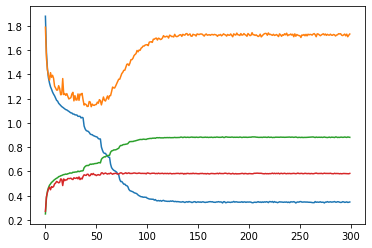

In [35]:
import pickle
plt.plot(hist), best_acc, curloss
pickle.dump(hist, open('./resnet50_finetune_hist.hdf5', 'wb'))

In [36]:
tuning_model = torch.load('./resnet50_finetune_model.pt')
pretrain_model = torch.load('./resnet50_model.pt')

In [50]:
# EVALUATE
model = tuning_model
model.eval()
running_valloss = 0.0
running_valacc = 0.0
_preds = []
_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    acc = float((torch.argmax(outputs, dim=1) == labels).float().sum())
    loss = criterion(outputs, labels)

    #         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc
    
    _preds.append(torch.argmax(outputs, dim=1).cpu().numpy())
    _labels.append(labels.cpu().numpy())

_preds = np.concatenate(_preds)
_labels = np.concatenate(_labels)
print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 1.471  | Avg. val_acc: 0.580


Text(0.5, 1, 'tuning')

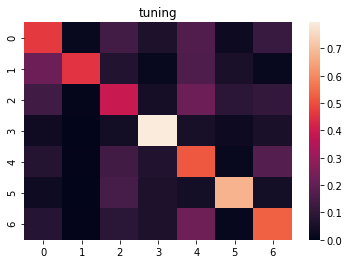

In [51]:
import seaborn as sn

sn.heatmap(confusion_matrix(_labels, _preds, normalize='true'))
plt.title('tuning')

Text(0.5, 1, 'pretrain')

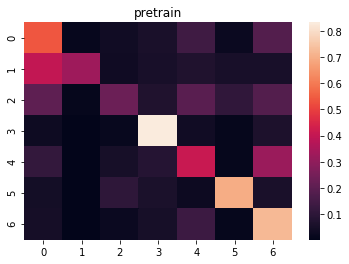

In [49]:
sn.heatmap(confusion_matrix(_labels, _preds, normalize='true'))
plt.title('pretrain')

In [46]:
label_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}